### Robots.txt User-Agent Metrics

See also
- the [data preparation notebook](./data-preparation-top-k-sample.ipynb) for data collection, and
- the [top-k metrics notebook](./metrics-top-k-sample.ipynb)
which were used to aggregate the data used in this notebook.

In [1]:
import datetime

from isoweek import Week

import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set_theme(style="whitegrid")

from matplotlib.colors import ListedColormap
my_color_map = ListedColormap(sns.color_palette('pastel').as_hex())

In [2]:
# read data

@staticmethod
def date_of(crawl):
    [_, _, year, week] = crawl.split('-')
    return Week(int(year), int(week)).monday()

top_k_list = [('1k', 1_000), ('10k', 10_000), ('50k', 50_000),
              ('100k', 100_000), ('1M', 1_000_000), ('2M', 2_000_000)]
ranks_max = 2042066

df = pd.read_csv('../../data/top-k-sample/robotstxt-user-agents-topk.csv')
df['dt'] = df['crawl'].apply(lambda c: date_of(c))
df['year'] = df['crawl'].apply(lambda c: int(c[8:12]))
df_user_agent_counts = df

df = pd.read_csv('../../data/top-k-sample/robotstxt-user-agents-topk-year.csv')
df['dt'] = df['year']
df_user_agent_counts_year = df

df = pd.read_csv('../../data/top-k-sample/robotstxt-status-counts-topk.csv')
df['dt'] = df['crawl'].apply(lambda c: date_of(c))
df['year'] = df['crawl'].apply(lambda c: int(c[8:12]))
df_status_counts = df

In [3]:
df = df_user_agent_counts_year

min_count_at_10k = 150
top_user_agents = set(df[(df['cnt'] >= min_count_at_10k)
                          & (df['top-k'] == '10k')]['useragent'].to_list())
top_user_agents

{'(any)',
 '*',
 'adsbot-google',
 'ahrefsbot',
 'amazonbot',
 'anthropic-ai',
 'applebot',
 'applebot-extended',
 'baiduspider',
 'bingbot',
 'blexbot',
 'bytespider',
 'ccbot',
 'chatgpt-user',
 'claude-web',
 'claudebot',
 'cohere-ai',
 'diffbot',
 'dotbot',
 'facebookbot',
 'facebookexternalhit',
 'google-extended',
 'googlebot',
 'googlebot-image',
 'googlebot-news',
 'gptbot',
 'ia_archiver',
 'imagesiftbot',
 'magpie-crawler',
 'mediapartners-google',
 'meta-externalagent',
 'meta-externalfetcher',
 'mj12bot',
 'msnbot',
 'oai-searchbot',
 'omgili',
 'omgilibot',
 'perplexitybot',
 'petalbot',
 'scrapy',
 'semrushbot',
 'slurp',
 'timpibot',
 'turnitinbot',
 'twitterbot',
 'yandex',
 'youbot'}

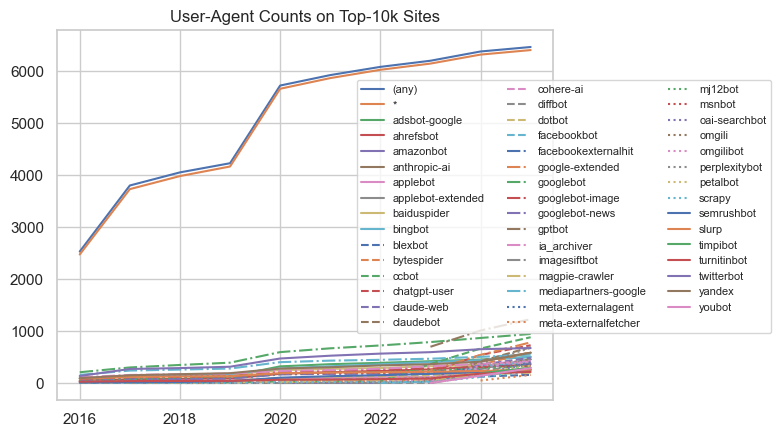

In [4]:
def plot_user_agents_over_time(df, top_k, user_agents, y='cnt',
                               dt='dt', log_scale=False, ax=None,
                               title=None):
    df = df[df['useragent'].isin(user_agents)]
    df = df[df['top-k'] == top_k]
    line_styles = ['-', '--', '-.', ':']
    line_styles = [line_styles[int(i/10)%len(line_styles)] for i in range(0, len(user_agents))]
    if not title:
        title = 'User-Agent Counts on Top-{} Sites'.format(top_k)
    pivot = df[[dt, 'useragent', y]].pivot(index=dt, columns='useragent', values=y)
    ax = pivot.plot(
        kind='line',
        ylabel=y,
        #cmap='tab10',
        style=line_styles,
        title=title,
        logy=log_scale,
        ax=ax)
    ax.legend(fontsize=8,
                loc='best', ncols=max(1, int(len(user_agents)/12)))
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')    
    return ax

# yearly aggregation
ax = plot_user_agents_over_time(df_user_agent_counts_year, '10k', top_user_agents)
ax.legend(fontsize=8, bbox_to_anchor=(1.45, .88),
          loc='upper right', ncols=max(1, int(len(top_user_agents)/12)))
ax.get_figure().savefig('img/user-agents-count-top10k.pdf', transparent=True)

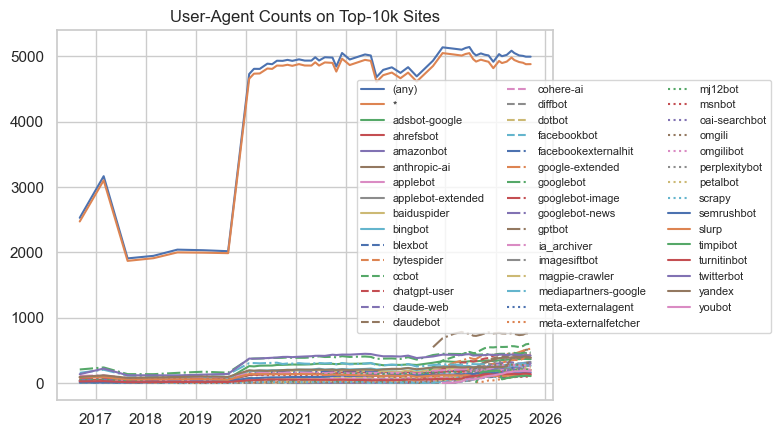

In [5]:
# monthly aggregation
ax = plot_user_agents_over_time(df_user_agent_counts, '10k', top_user_agents)
ax.legend(fontsize=8, bbox_to_anchor=(1.45, .88),
          loc='upper right', ncols=max(1, int(len(top_user_agents)/12)))
ax.get_figure().savefig('img/user-agents-count-top10k.pdf', transparent=True)

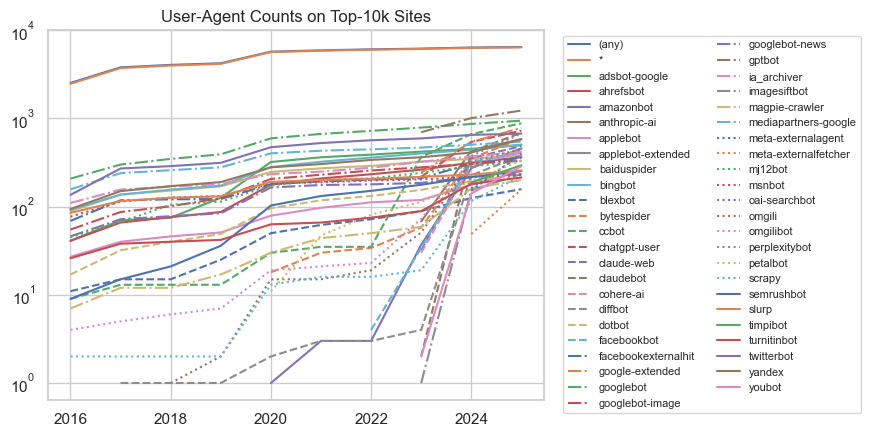

In [6]:
# counts log-scale
ax = plot_user_agents_over_time(df_user_agent_counts_year, '10k', top_user_agents, log_scale=True)
ax.legend(fontsize=8, bbox_to_anchor=(1.65, 1),
          loc='upper right', ncols=max(1, int(len(top_user_agents)/20)))
ax.get_figure().savefig('img/user-agent-count-top10k-logscale.pdf', transparent=True)

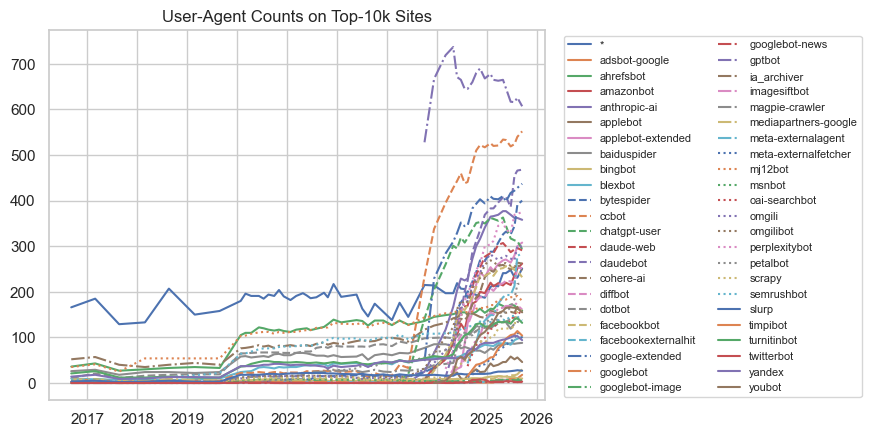

In [7]:
# disallow-all (instead of count)
ax = plot_user_agents_over_time(df_user_agent_counts, '10k',
                                top_user_agents.difference({'(any)'}), y='disallow-all')
ax.legend(fontsize=8, bbox_to_anchor=(1.65, 1),
          loc='upper right', ncols=max(1, int(len(top_user_agents)/20)))
ax.get_figure().savefig('img/user-agents-disallowed-top10k.pdf', transparent=True)

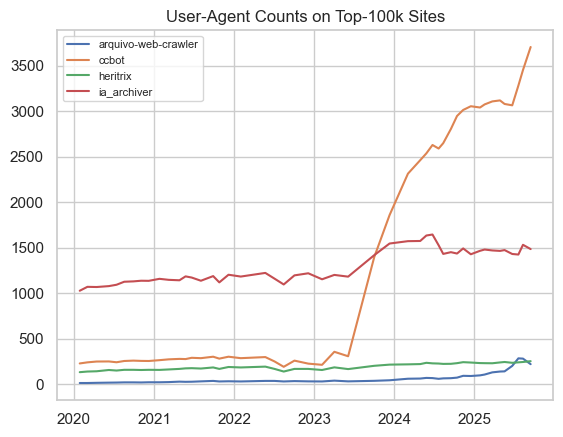

In [8]:
# user-agents categorized, cf. https://radar.cloudflare.com/bots#verified-bots

user_agents_by_category = {
    #'General': {'*', 'httrack', nutch', 'wget'},
    'Search Engine': {
        'baiduspider', 'bingbot', 'googlebot', 'googlebot-image',
        'msnbot', 'seznambot', 'slurp', 'yandex', 'yandexbot'},
    'Advertising': {
        'adsbot-google', 'mediapartners-google'},
    'SEO': {
        'ahrefsbot', 'ahrefssiteaudit', 'blexbot', 'dotbot', 'mj12bot',
        'rogerbot', 'semrushbot', },
    'AI Crawler': {
        'applebot-extended',
        'amazonbot', 'anthropic-ai', 'bytespider', 'ccbot', 
        'claudebot', 'cohere-training-data-crawler',
        'diffbot', 'google-extended', #'googleother',
        'gptbot',
        'meta-externalagent',
        'petalbot', # 'qualifiedbot',
        'timpibot', },
    'AI Agent': {
        'chatgpt-user', 'perplexity-user',  'claude-user', 'claude-web',
    },
    'AI Search': {
        'applebot', 'oai-searchbot', 'claude-searchbot', 'perplexitybot',
    },
    'Page Preview': {
        'googleimageproxy', 'meta-externalfetcher', 'twitterbot'},
    'Web Archiving': {
        'arquivo-web-crawler', 'ccbot', 'ia_archiver', 'heritrix'}, # 'archivebot', 
}

top_k = '100k'
df = df_user_agent_counts
df = df[df['year'].isin(range(2020,2026))]

ax = plot_user_agents_over_time(df, top_k, user_agents_by_category['Web Archiving'])
ax.get_figure().savefig('img/user-agent-count-top-100k-web-archiving.pdf', transparent=True)

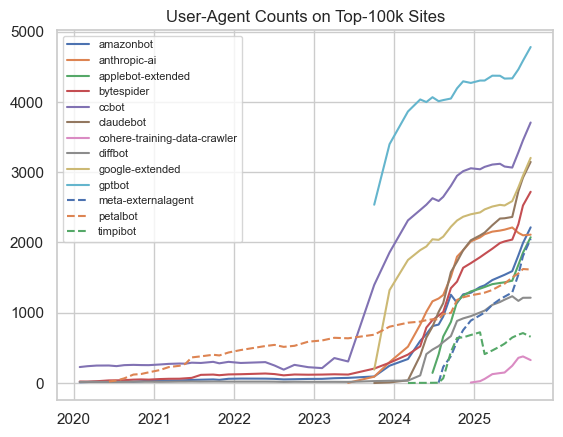

In [9]:
ax = plot_user_agents_over_time(df, top_k, user_agents_by_category['AI Crawler'])
ax.get_figure().savefig('img/user-agent-count-top-100k-ai.pdf', transparent=True)

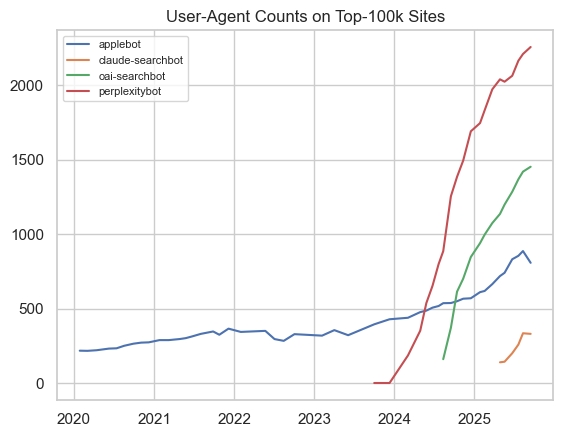

In [10]:
ax = plot_user_agents_over_time(df, top_k, user_agents_by_category['AI Search'])
ax.get_figure().savefig('img/user-agent-count-top-100k-ai.pdf', transparent=True)

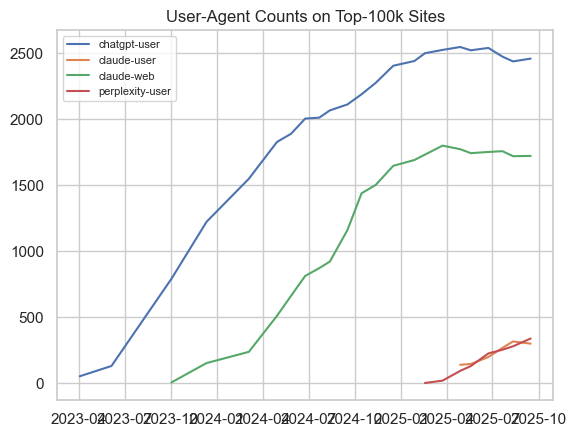

In [11]:
ax = plot_user_agents_over_time(df, top_k, user_agents_by_category['AI Agent'])
ax.get_figure().savefig('img/user-agent-count-top-100k-ai.pdf', transparent=True)

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

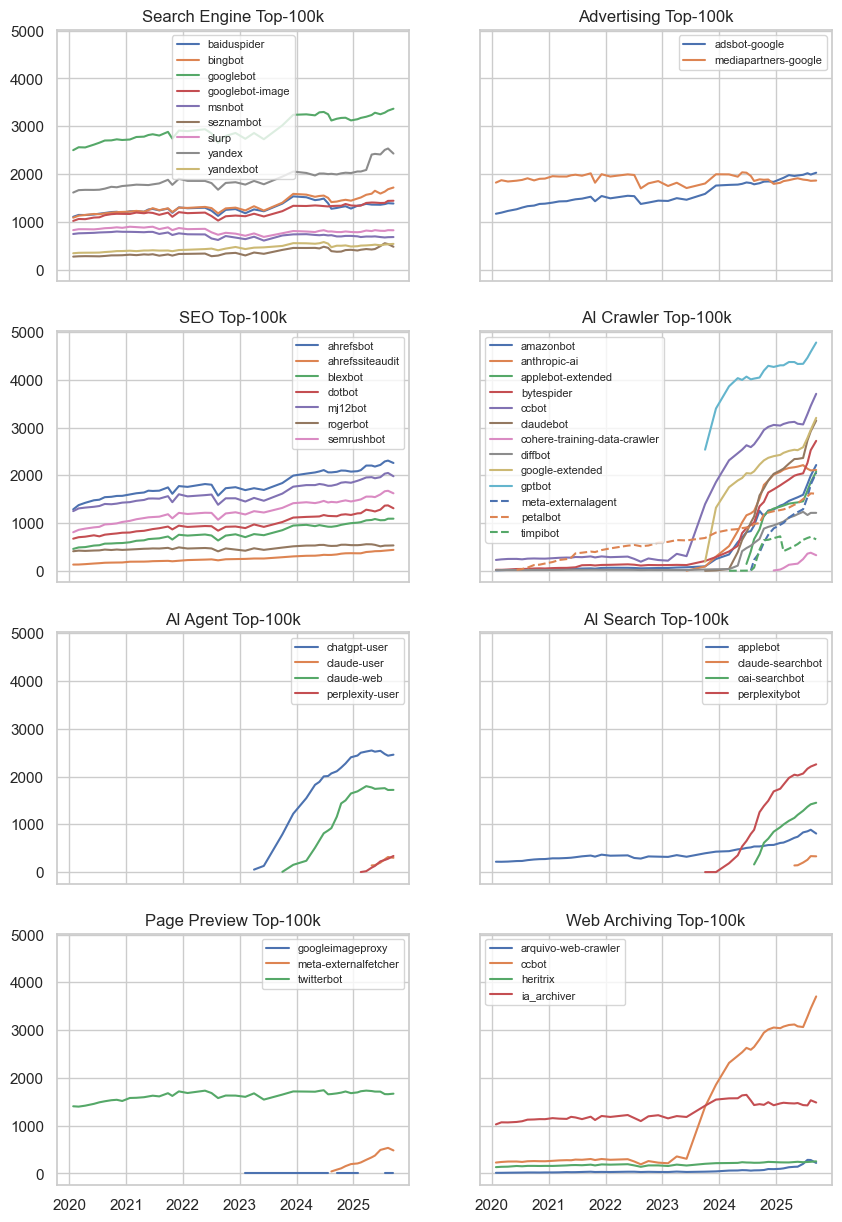

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True,
                         squeeze=False, figsize=[10,15])

top_k = '100k'

n = 0
for cat in user_agents_by_category:
    ax = plot_user_agents_over_time(df, top_k, user_agents_by_category[cat],
                                      ax=axes[int(n/2),n%2],
                                      title=(cat + ' Top-' + top_k))
    ax.xaxis.set_label_text("")
    n += 1
#plt.savefig('img/robotstxt-status-counts-topk.pdf', transparent=True)
plt

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

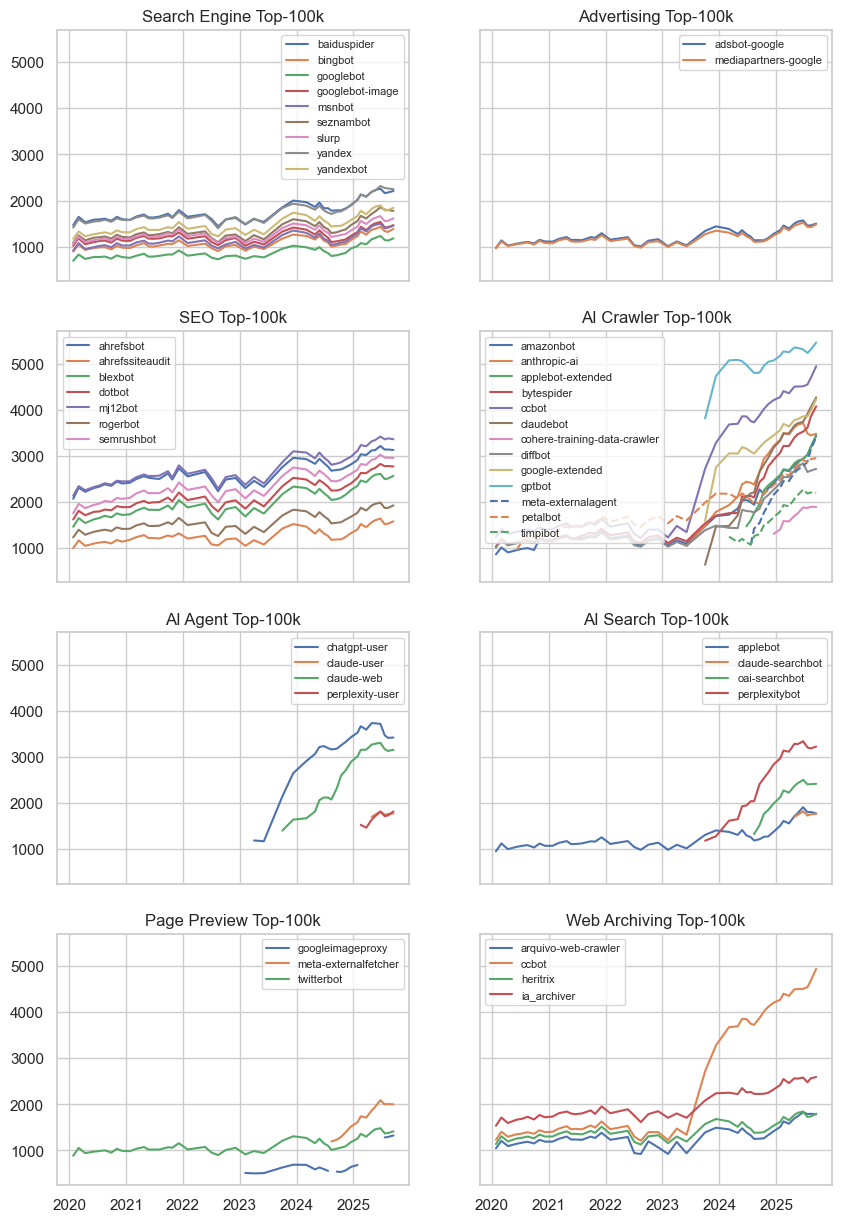

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True,
                         squeeze=False, figsize=[10,15])

n = 0
for cat in user_agents_by_category:
    plot = plot_user_agents_over_time(df, top_k, user_agents_by_category[cat],
                                      y='*-disallow-all', ax=axes[int(n/2),n%2],
                                      title=(cat + ' Top-' + top_k))
    plot.xaxis.set_label_text("")
    n += 1
#plt.savefig('img/robotstxt-status-counts-topk.pdf', transparent=True)
plt

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

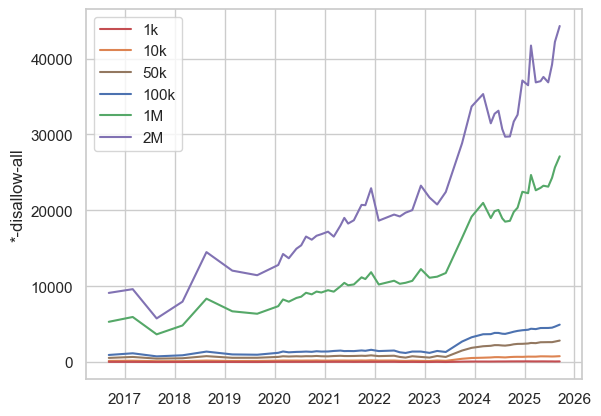

In [14]:
# count disallowed sites for "CCBot" or wildcard user-agent
# - based only on robots.txt rules

df = df_user_agent_counts
df = df[df['useragent'] == 'ccbot'].drop(['year'], axis='columns')

y = '*-disallow-all'
pivot = df[['dt', 'top-k', y]].pivot(index='dt', columns='top-k', values=y)

ax = pivot.plot(
        kind='line', style='-',
        ylabel=y,
        #cmap='tab10',
        title='',
        logy=False)
label_order = [3, 1, 5, 0, 2, 4]
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])
ax.xaxis.set_label_text('')
plt

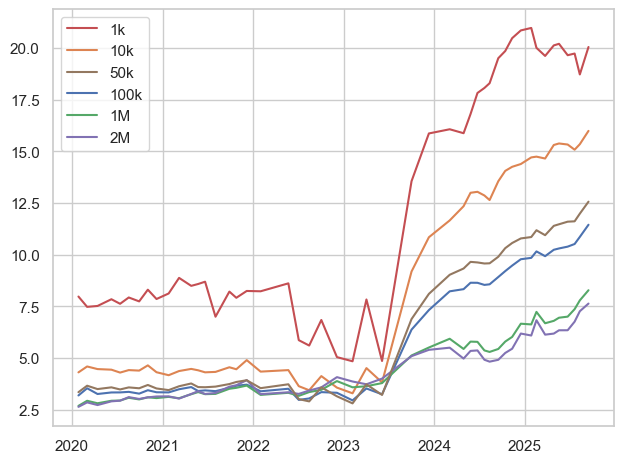

In [15]:
# percentage of sites entirely disallowed for user-agent "CCBot" (or per wildcard user-agent)
# - based only on robots.txt rules

df = df_user_agent_counts
df = df[df['useragent'] == 'ccbot']
df_perc = df[['dt', 'year', 'crawl', 'top-k']]
df_perc['CCBot allow'] = 100.0 * (df['*-allow-all'] + df['*-allow-part']) / (df['*-disallow-all'] + df['*-allow-part'] + df['*-allow-all'])
df_perc['CCBot disallow'] = 100.0 * (df['*-disallow-all']) / (df['*-disallow-all'] + df['*-allow-part'] + df['*-allow-all'])

ax = df_perc[df_perc['year'].isin(range(2020, 2026))].pivot(
    index='dt', columns='top-k', values='CCBot disallow').plot(
        kind='line', style='-',
         #cmap='tab10',
        title='',
        logy=False)
handles, labels = ax.get_legend_handles_labels()
label_order = [3, 1, 5, 0, 2, 4]
ax.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])
ax.xaxis.set_label_text('')
ax.get_figure().tight_layout()
ax.get_figure().savefig('img/robotstxt-ccbot-disallowed.pdf', transparent=True)

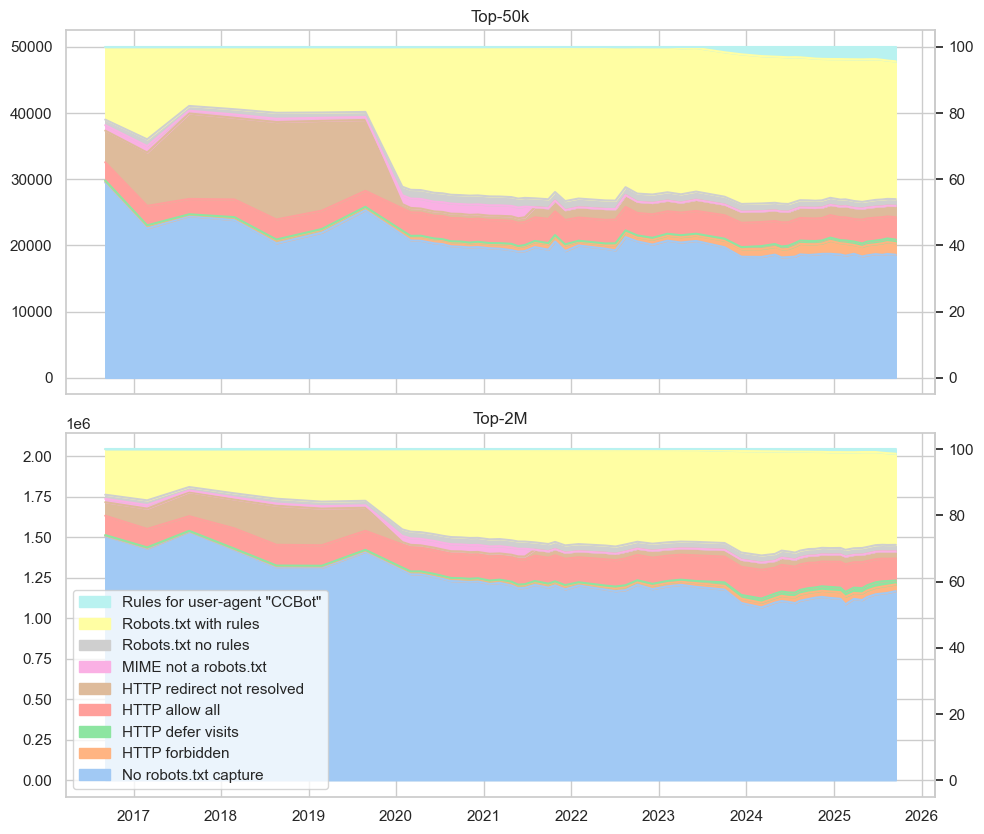

In [16]:
# status counts + rules for user-agent "CCBot"

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False,
                         squeeze=False, figsize=[10,8.5])

df1 = df_status_counts

df2 = df_user_agent_counts[df_user_agent_counts['useragent'] == 'ccbot']

df = df1.merge(df2[['year', 'dt', 'crawl', 'top-k', 'cnt']],
               on=['year', 'dt', 'crawl', 'top-k'], suffixes=('_x', '_y'))

df['Robots.txt with rules'] = (df['Robots.txt with rules'] - df['cnt'])
df.rename({'cnt': 'Rules for user-agent "CCBot"'}, axis='columns', inplace=True)
df.drop(['year'], axis='columns', inplace=True)

def percentage(x, total):
    return 100.0 * (x / total)

n = 0
for top_k, top_k_max in [('50k', 5_000), ('2M', ranks_max)]:
    ax = df[df['top-k'] == top_k].plot(
        x='dt',
        kind='area',
        stacked=True,
        #ax=axes[int(n/2),n%2],
        ax=axes[n,0],
        title='Top-'+top_k,
        cmap=my_color_map)
    handles, labels = ax.get_legend_handles_labels()
    if (n % 2) == 0:
        ax.legend().remove()
        ax2 = ax.secondary_yaxis('right', functions=(lambda x: percentage(x, 50_000),
                                                     lambda x: percentage(x, 50_000)))
    else:
        ax.legend(reversed(handles), reversed(labels))
        ax.secondary_yaxis('right', functions=(lambda x: percentage(x, ranks_max),
                                               lambda x: percentage(x, ranks_max)))
    ax.xaxis.set_label_text("")
    n += 1
fig.tight_layout()
fig.savefig('img/robotstxt-status-ccbot.pdf', transparent=True)

In [17]:
# status counts and whether "CCBot" is allowed (all, partially, disallowed)

# merge status counts and robots.txt rule class of CCBot
df1 = df_status_counts
df2 = df_user_agent_counts[df_user_agent_counts['useragent'] == 'ccbot']
df = df1.merge(df2[['year', 'dt', 'crawl', 'top-k', '*-disallow-all', '*-allow-part', '*-allow-all']],
               on=['year', 'dt', 'crawl', 'top-k'], suffixes=('_x', '_y'))
# if CCBot and the wildard user-agent are not mentioned in the rules, this means "allow all"
ccbot_not_mentioned = (df['Robots.txt with rules']
                      - df['*-disallow-all'] - df['*-allow-part'] - df['*-allow-all'])
df['*-allow-all'] += ccbot_not_mentioned
df.drop(['Robots.txt with rules'], axis='columns', inplace=True)
df.rename({'*-disallow-all': 'CCBot disallow all',
           '*-allow-part': 'CCBot allow part',
           '*-allow-all': 'CCBot allow all'},
          axis='columns', inplace=True)
df[df['crawl'] == 'CC-MAIN-2025-08']

,crawl,top-k,No robots.txt capture,HTTP forbidden,HTTP defer visits,HTTP allow all,HTTP redirect not resolved,MIME not a robots.txt,Robots.txt no rules,dt,year,CCBot disallow all,CCBot allow part,CCBot allow all
47,CC-MAIN-2025-08,1k,324,27,12,64,44,0,9,2025-02-17,2025,103,383,34
102,CC-MAIN-2025-08,10k,3370,345,91,628,369,0,195,2025-02-17,2025,728,3774,500
157,CC-MAIN-2025-08,50k,18449,1818,493,3484,1691,0,1030,2025-02-17,2025,2533,17380,3122
212,CC-MAIN-2025-08,100k,38592,3472,1062,7378,3241,0,2224,2025-02-17,2025,4404,32947,6680
267,CC-MAIN-2025-08,1M,479478,26968,12181,86081,26210,0,22681,2025-02-17,2025,24666,239710,82025
322,CC-MAIN-2025-08,2M,1085438,46854,29618,170759,47874,0,41205,2025-02-17,2025,41720,422623,155975


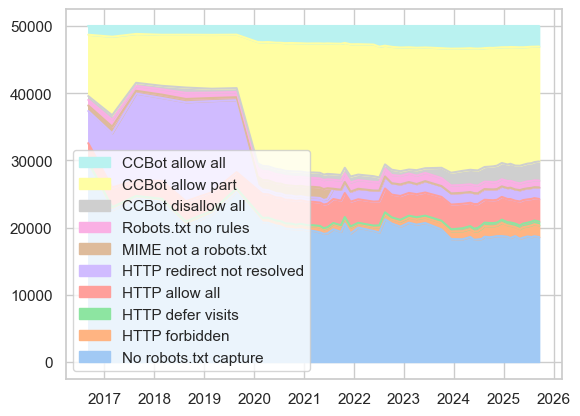

In [18]:
ax = df[df['top-k'] == '50k'].drop(['year'], axis='columns').plot(
        x='dt', kind='area', stacked=True, cmap=my_color_map)
# axes.legend(fontsize=7)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
ax.xaxis.set_label_text("")
ax.get_figure().savefig('img/robotstxt-allowed-ccbot.pdf', transparent=True)

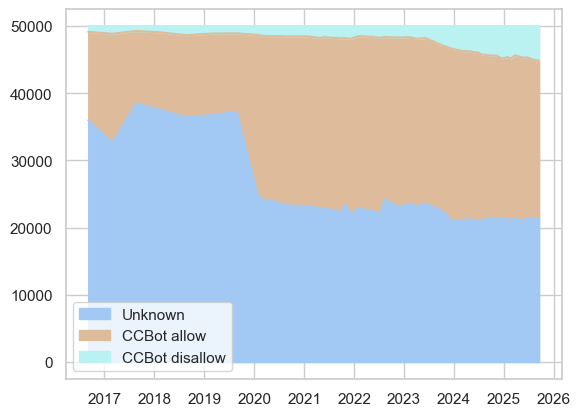

In [19]:
# status and rules for user-agent "CCBot" as three classes "Unknown", "Allow", "Disallow"
# - both, robots.txt rules and HTTP status codes are assigned to "Allow" and "Disallow"

df['Unknown'] = (df['No robots.txt capture'] + df['HTTP redirect not resolved']
                 + df['Robots.txt no rules'] + df['MIME not a robots.txt'])
df['CCBot allow'] = (df['CCBot allow all'] + df['CCBot allow part'] + df['HTTP allow all'])
df['CCBot disallow'] = (df['CCBot disallow all'] + df['HTTP forbidden'] + df['HTTP defer visits'])

ax = df[df['top-k'] == '50k'][['dt', 'Unknown', 'CCBot allow', 'CCBot disallow']].plot(
        x='dt', kind='area', stacked=True, cmap=my_color_map)
# axes.legend(fontsize=7)
handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels))
ax.xaxis.set_label_text('')
ax.get_figure().savefig('img/robotstxt-allowed-ccbot.pdf', transparent=True)

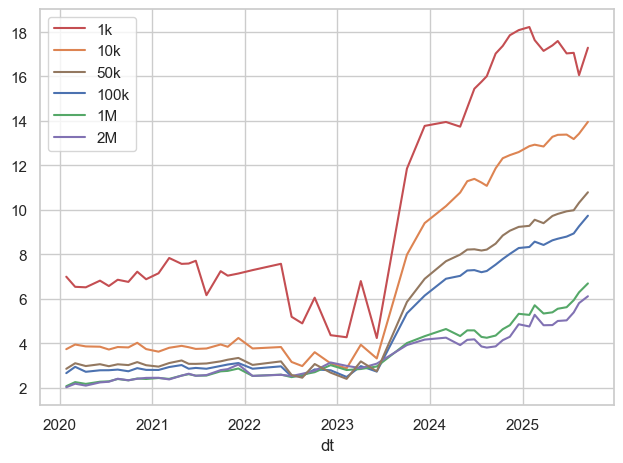

In [20]:
# percentage of sites entirely disallowed for user-agent "CCBot" (or per wildcard user-agent)
# - both, robots.txt rules and HTTP status codes used as indicators

df_perc = df[['dt', 'year', 'crawl', 'top-k']]
df_perc['CCBot allow'] = 100.0 * df['CCBot allow'] / (df['CCBot allow'] + df['CCBot disallow all'])
df_perc['CCBot disallow'] = 100.0 * df['CCBot disallow all'] / (df['CCBot allow'] + df['CCBot disallow all'])

ax = df_perc[df_perc['year'].isin(range(2020, 2026))].pivot(
    index='dt', columns='top-k', values='CCBot disallow').plot(
        kind='line', style='-',
         #cmap='tab10',
        title='',
        logy=False)
handles, labels = ax.get_legend_handles_labels()
label_order = [3, 1, 5, 0, 2, 4]
ax.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])
ax.get_figure().tight_layout()
ax.get_figure().savefig('img/robotstxt-and-http-ccbot-disallowed.pdf', transparent=True)

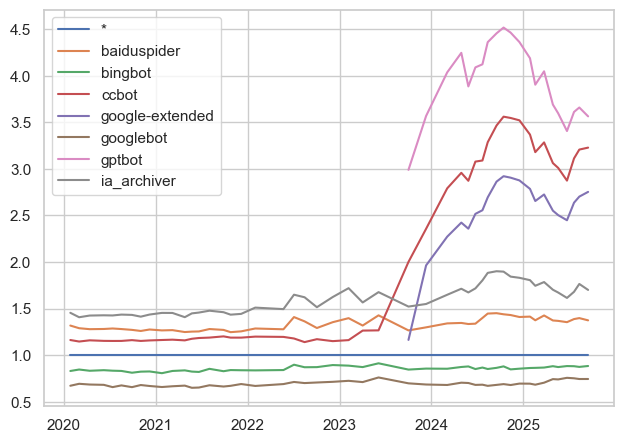

In [21]:
# comparing user-agents by the number of disallowed sites
# ratio: disallowed for user-agent x / disallowed for the wildcard user-agent

df = df_user_agent_counts
user_agents = ['*', 'ccbot', 'googlebot', 'bingbot', 'baiduspider', 'ia_archiver',
               'gptbot', 'google-extended'] # 'chatgpt-user', 'claudebot', 'anthropic-ai', 
top_k = '50k'
df = df[df['useragent'].isin(user_agents) & (df['top-k'] == top_k)]
d1 = df[['dt', 'top-k', 'useragent', '*-disallow-all']]
d2 = d1[d1['useragent'] == '*'][['dt', 'top-k', '*-disallow-all']]
df = d1.merge(d2, on=['dt', 'top-k'], suffixes=('', '_wildcard'))
# normalize: number of disallowed sites / number of disallowed sites for wildcard user-agent
df['*-disallow-all-normalized'] = df['*-disallow-all'] / df['*-disallow-all_wildcard']
# from 2020 onwards
df = df[df['dt'] >= datetime.date(2020, 1, 1)]
ax = df[['dt', 'useragent', '*-disallow-all-normalized']].pivot(
        index='dt', columns='useragent', values='*-disallow-all-normalized').plot(
    kind='line', style='-', title='')
ax.get_legend().set_title('')
ax.get_figure().tight_layout()
ax.xaxis.set_label_text('')
ax.get_figure().savefig('img/robotstxt-bias-user-agents-normalized.pdf', transparent=True)

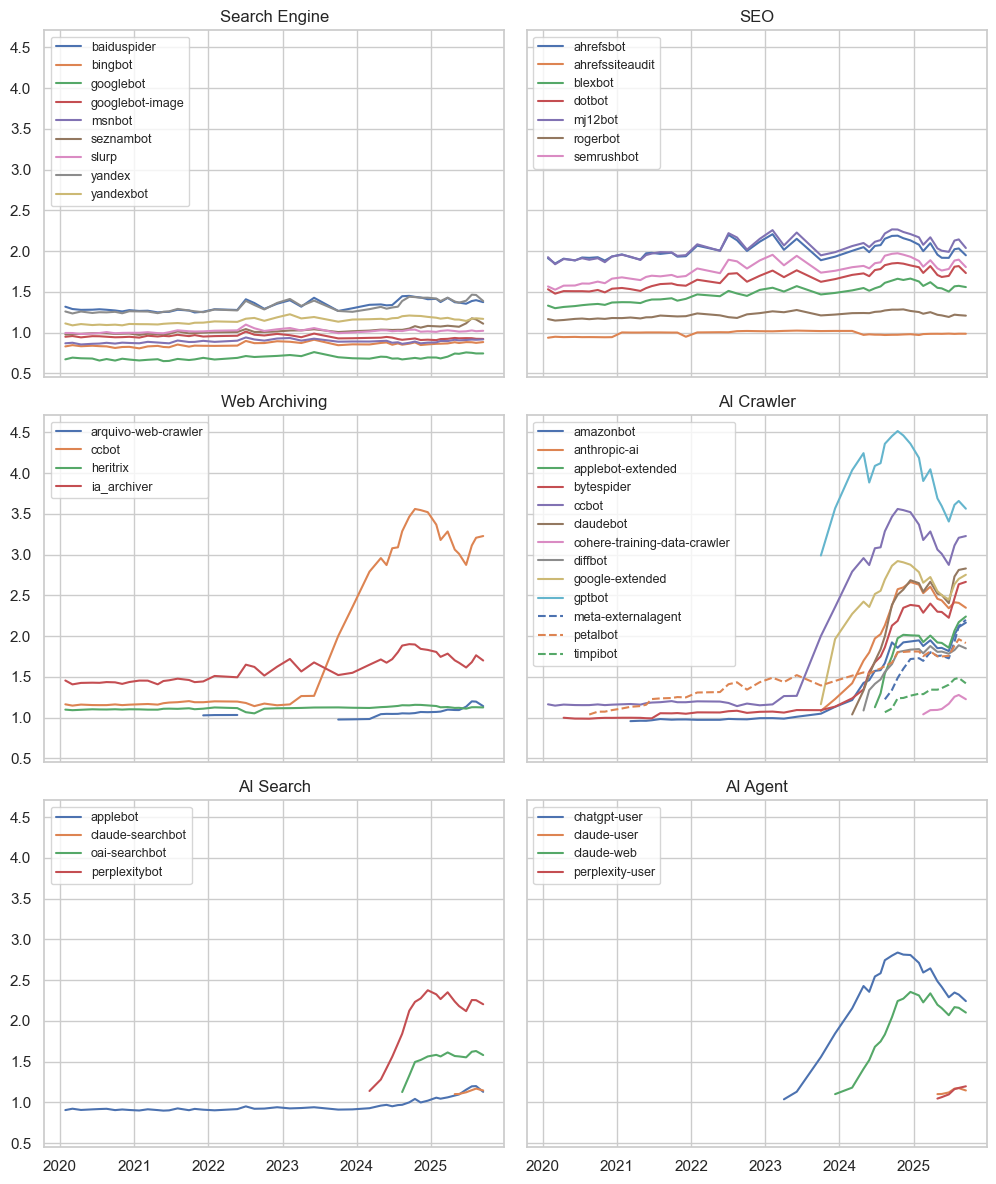

In [22]:
# 

df = df_user_agent_counts

categories = ['Search Engine', 'SEO', 'Web Archiving', 'AI Crawler', 'AI Search', 'AI Agent']
top_k = '50k'
# skip data points which are based on a low count
min_count = 20
years_select = sorted(range(2020, 2026))

user_agents = set().union(*map(lambda c: user_agents_by_category[c], categories)).union({'*'})

# filter on user-agent and year
df = df[df['useragent'].isin(user_agents) & df['year'].isin(years_select)]
d1 = df[['dt', 'top-k', 'useragent', '*-disallow-all', 'cnt']]
# normalize: number of disallowed sites / number of disallowed sites for wildcard user-agent
d2 = d1[d1['useragent'] == '*'][['dt', 'top-k', '*-disallow-all']]
df = d1.merge(d2, on=['dt', 'top-k'], suffixes=('', '_wildcard'))
df['*-disallow-all-normalized'] = df['*-disallow-all'] / df['*-disallow-all_wildcard']
df = df[df['cnt'] >= min_count]
df = df[['dt', 'top-k', 'useragent', '*-disallow-all-normalized']]
df = df[df['top-k'] == top_k]

line_styles = ['solid', 'dashed', 'dashdot']

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                         squeeze=False, figsize=[10,12])
n = 0
for cat in categories:
    ax = plot_user_agents_over_time(df, top_k, user_agents_by_category[cat].difference({'*'}),
                                    y='*-disallow-all-normalized', ax=axes[int(n/2),n%2],
                                    title=cat, log_scale=False)
    ax.yaxis.set_label_text('')
    ax.legend(fontsize=9,
              loc='upper left',
              ncols=max(1, int(len(user_agents_by_category[cat])/12)))
    #ax[0].set_linestyle(line_styles[n%len(line_styles)])
    n += 1
fig.tight_layout()
fig.savefig('img/robotstxt-bias-user-agents-categorized.pdf', transparent=True)

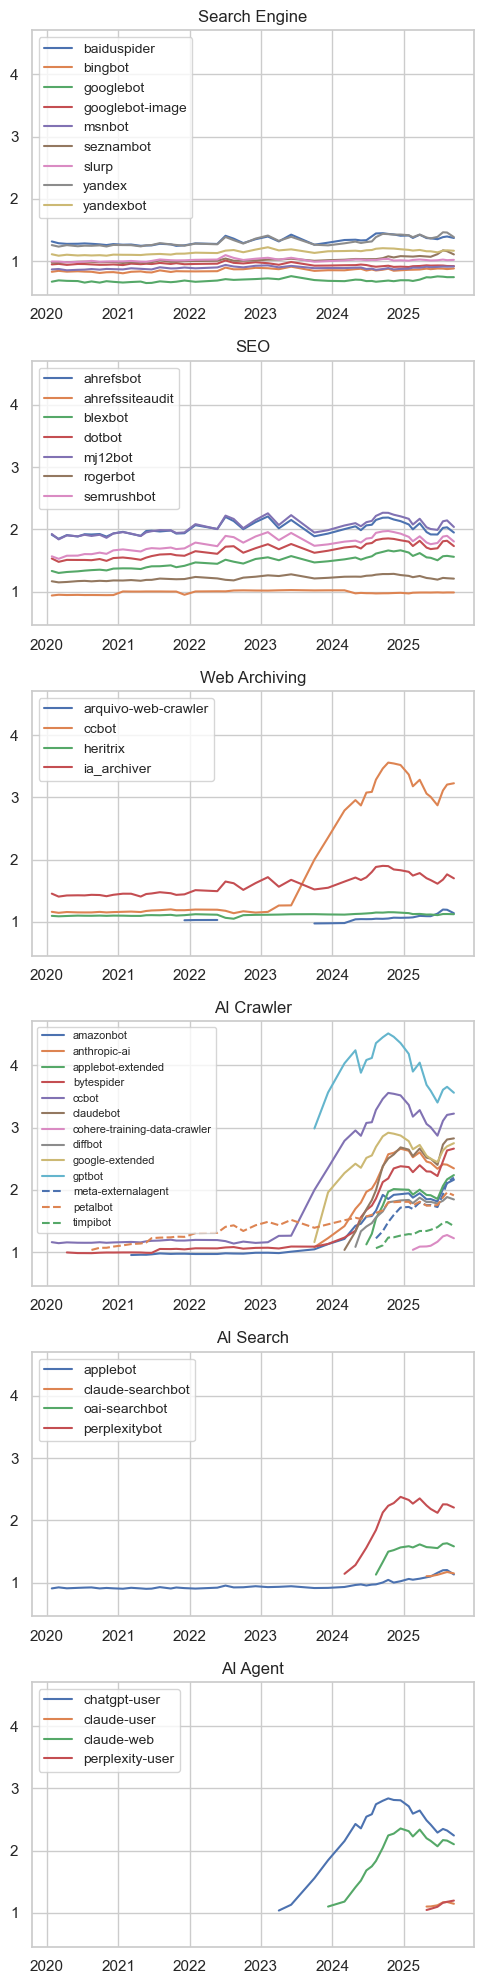

In [23]:
# one column for slides
fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True,
                         squeeze=False, figsize=[5,20])
#axes.tick_params()
n = 0
for cat in categories:
    #if cat not in ['Search Engine', 'SEO', 'AI Crawler']:
    #    continue
    ax = plot_user_agents_over_time(df, top_k, user_agents_by_category[cat].difference({'*'}),
                                    y='*-disallow-all-normalized', ax=axes[n,0],
                                    title=cat, log_scale=False)
    ax.yaxis.set_label_text('')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.legend(fontsize=10 if len(user_agents_by_category[cat]) < 10 else 8,
              loc='upper left',
              ncols=max(1, int(len(user_agents_by_category[cat])/12)))
    n += 1

for ax in axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)

fig.tight_layout()
fig.savefig('img/robotstxt-bias-user-agents-categorized-slides.pdf', transparent=True)

In [24]:
# tabular view:
# counts of user-agents addressed in robots.txt files

#years_select = sorted(set(map(lambda s: int(s[8:12]), crawls)))
years_select = sorted(range(2016, 2026))

top_k = '10k'

df = df_user_agent_counts_year

df = df[df['year'].isin(years_select) & (df['top-k'] == top_k) & df['useragent'].isin(top_user_agents)]

ua_agent_share_by_year = df[['useragent', 'year', 'cnt']] \
    .set_index('useragent').pivot(columns='year', values='cnt')
ua_agent_share_by_year.index.rename('user-agent', inplace=True)
ua_agent_share_by_year.fillna(0, inplace=True)
ua_agent_share_by_year = ua_agent_share_by_year.astype(int, errors='raise', copy=False)
#ua_agent_share_by_year.sort_values([2024], ascending=False, inplace=True)
ua_agent_share_by_year

year,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
user-agent,,,,,,,,,,
(any),2529,3799,4051,4227,5721,5922,6080,6198,6376,6462
*,2473,3729,3980,4164,5659,5864,6024,6143,6316,6403
adsbot-google,41,70,75,126,321,363,389,420,452,498
ahrefsbot,41,66,76,87,177,209,233,263,315,364
amazonbot,0,0,0,0,1,3,3,37,273,457
anthropic-ai,0,0,0,0,0,0,0,68,433,583
applebot,27,40,46,51,79,97,112,119,177,254
applebot-extended,0,0,0,0,0,0,0,0,276,454
baiduspider,89,137,152,170,248,272,290,323,348,383


In [25]:
# LaTeX table export
print(ua_agent_share_by_year.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
year & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 & 2023 & 2024 & 2025 \\
user-agent &  &  &  &  &  &  &  &  &  &  \\
\midrule
(any) & 2529 & 3799 & 4051 & 4227 & 5721 & 5922 & 6080 & 6198 & 6376 & 6462 \\
* & 2473 & 3729 & 3980 & 4164 & 5659 & 5864 & 6024 & 6143 & 6316 & 6403 \\
adsbot-google & 41 & 70 & 75 & 126 & 321 & 363 & 389 & 420 & 452 & 498 \\
ahrefsbot & 41 & 66 & 76 & 87 & 177 & 209 & 233 & 263 & 315 & 364 \\
amazonbot & 0 & 0 & 0 & 0 & 1 & 3 & 3 & 37 & 273 & 457 \\
anthropic-ai & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 68 & 433 & 583 \\
applebot & 27 & 40 & 46 & 51 & 79 & 97 & 112 & 119 & 177 & 254 \\
applebot-extended & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 276 & 454 \\
baiduspider & 89 & 137 & 152 & 170 & 248 & 272 & 290 & 323 & 348 & 383 \\
bingbot & 92 & 137 & 156 & 173 & 281 & 323 & 360 & 401 & 442 & 506 \\
blexbot & 11 & 15 & 15 & 25 & 50 & 62 & 72 & 89 & 125 & 158 \\
bytespider & 0 & 0 & 0 & 0 & 18 & 30 & 34 & 58 & 353 & 593 \\
ccbot & 9 & 13 